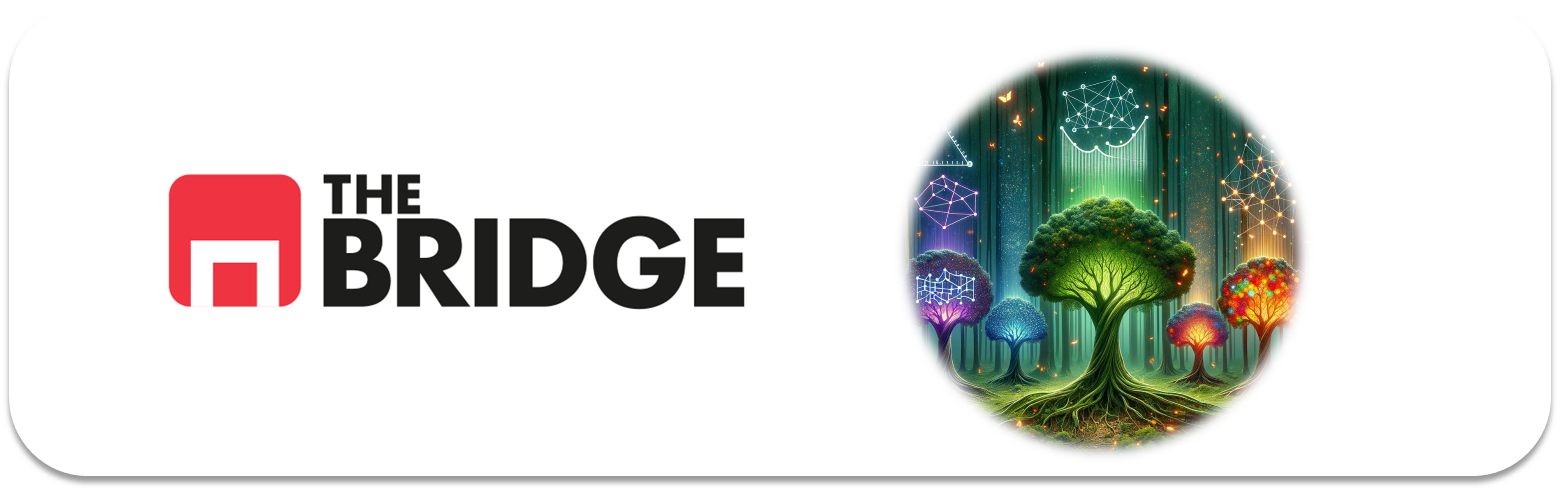

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

import seaborn as sns


np.random.seed(42)


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
df = pd.read_csv("./data/bank-full.csv", sep = ";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


<Axes: xlabel='y', ylabel='count'>

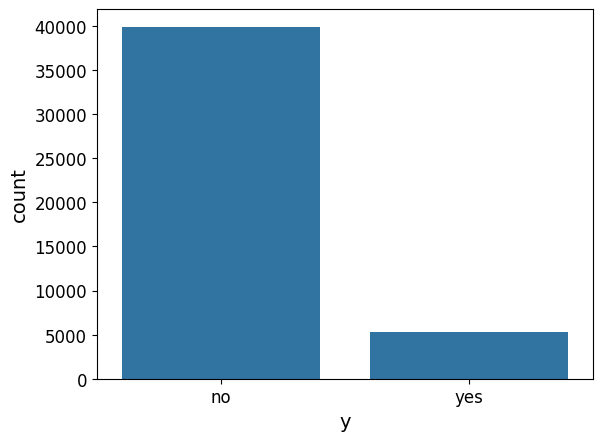

In [4]:
y = df["y"]

sns.countplot(data=df, x = y)

In [5]:
y = pd.DataFrame(y)
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [6]:
y = y['y'].map({'no': 0, 'yes': 1})

In [7]:
X = df.drop(["y"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 42)

In [8]:
df_eda = X_train.copy()
df_eda["y"] = y_train.copy()


In [9]:
df_eda

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,72,1,-1,0,unknown,0
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0,unknown,0
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0,unknown,0
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,375,11,-1,0,unknown,0
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,2093,1,-1,0,unknown,1
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,92,1,failure,0
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0,unknown,0
860,33,retired,married,secondary,no,165,no,no,unknown,7,may,111,1,-1,0,unknown,0


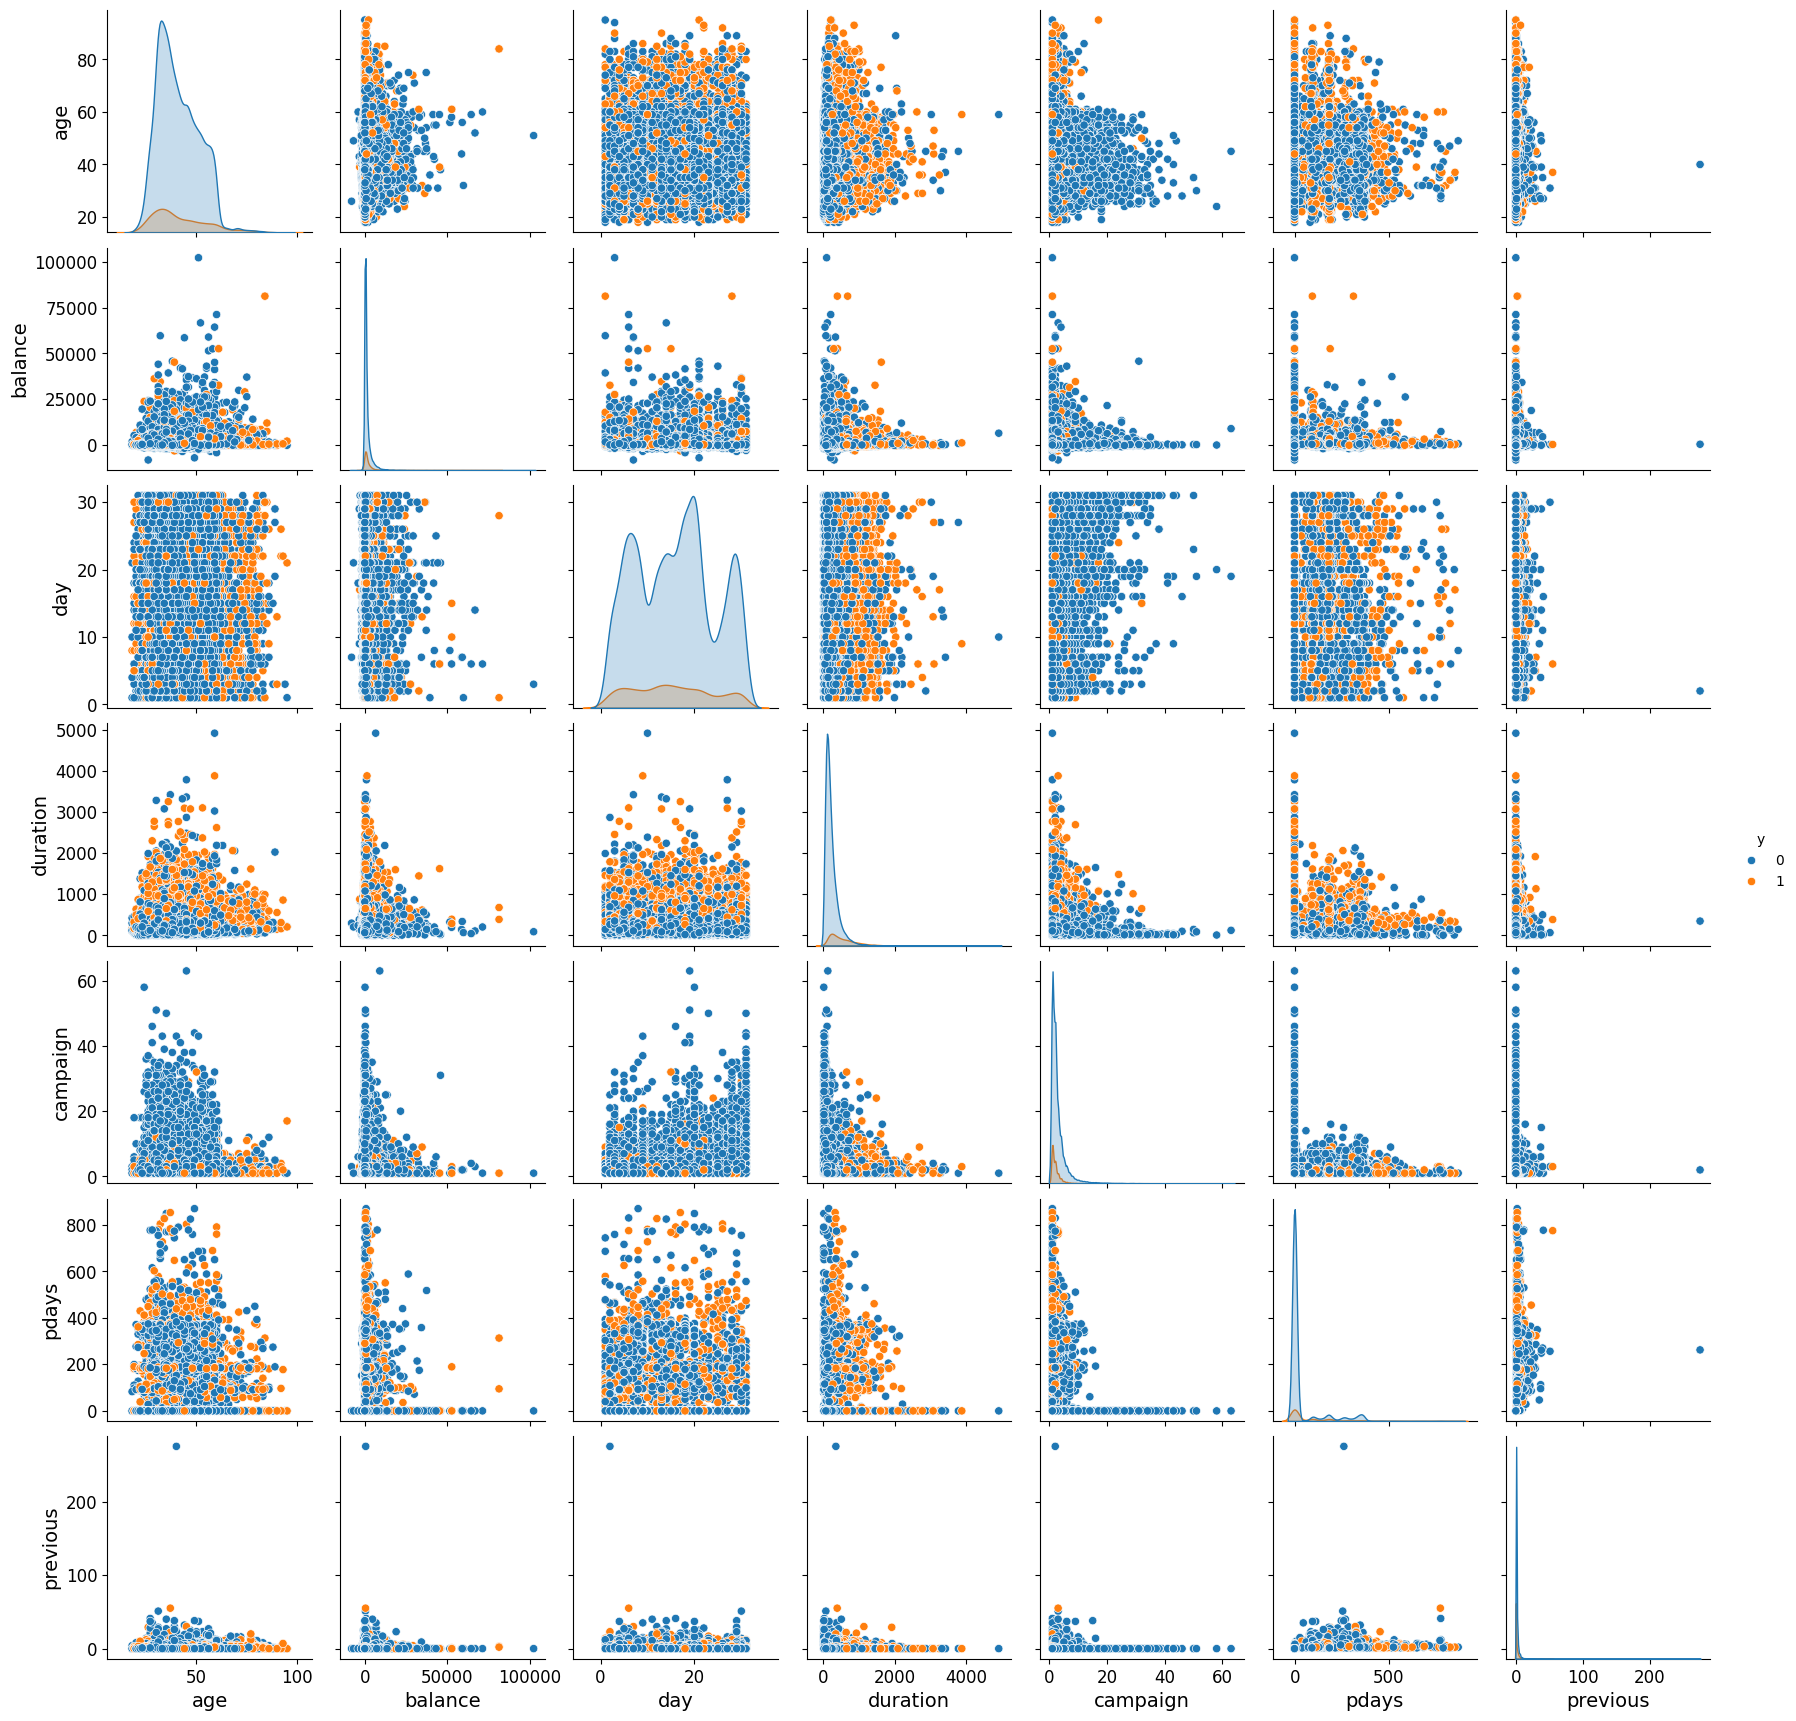

In [10]:
sns.pairplot(data = df_eda, hue = "y")

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

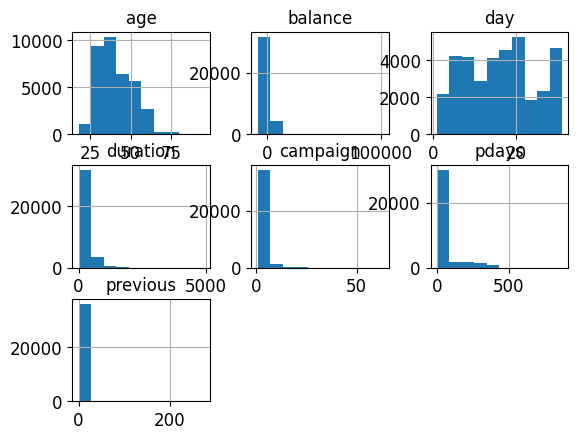

In [11]:
X_train.hist()

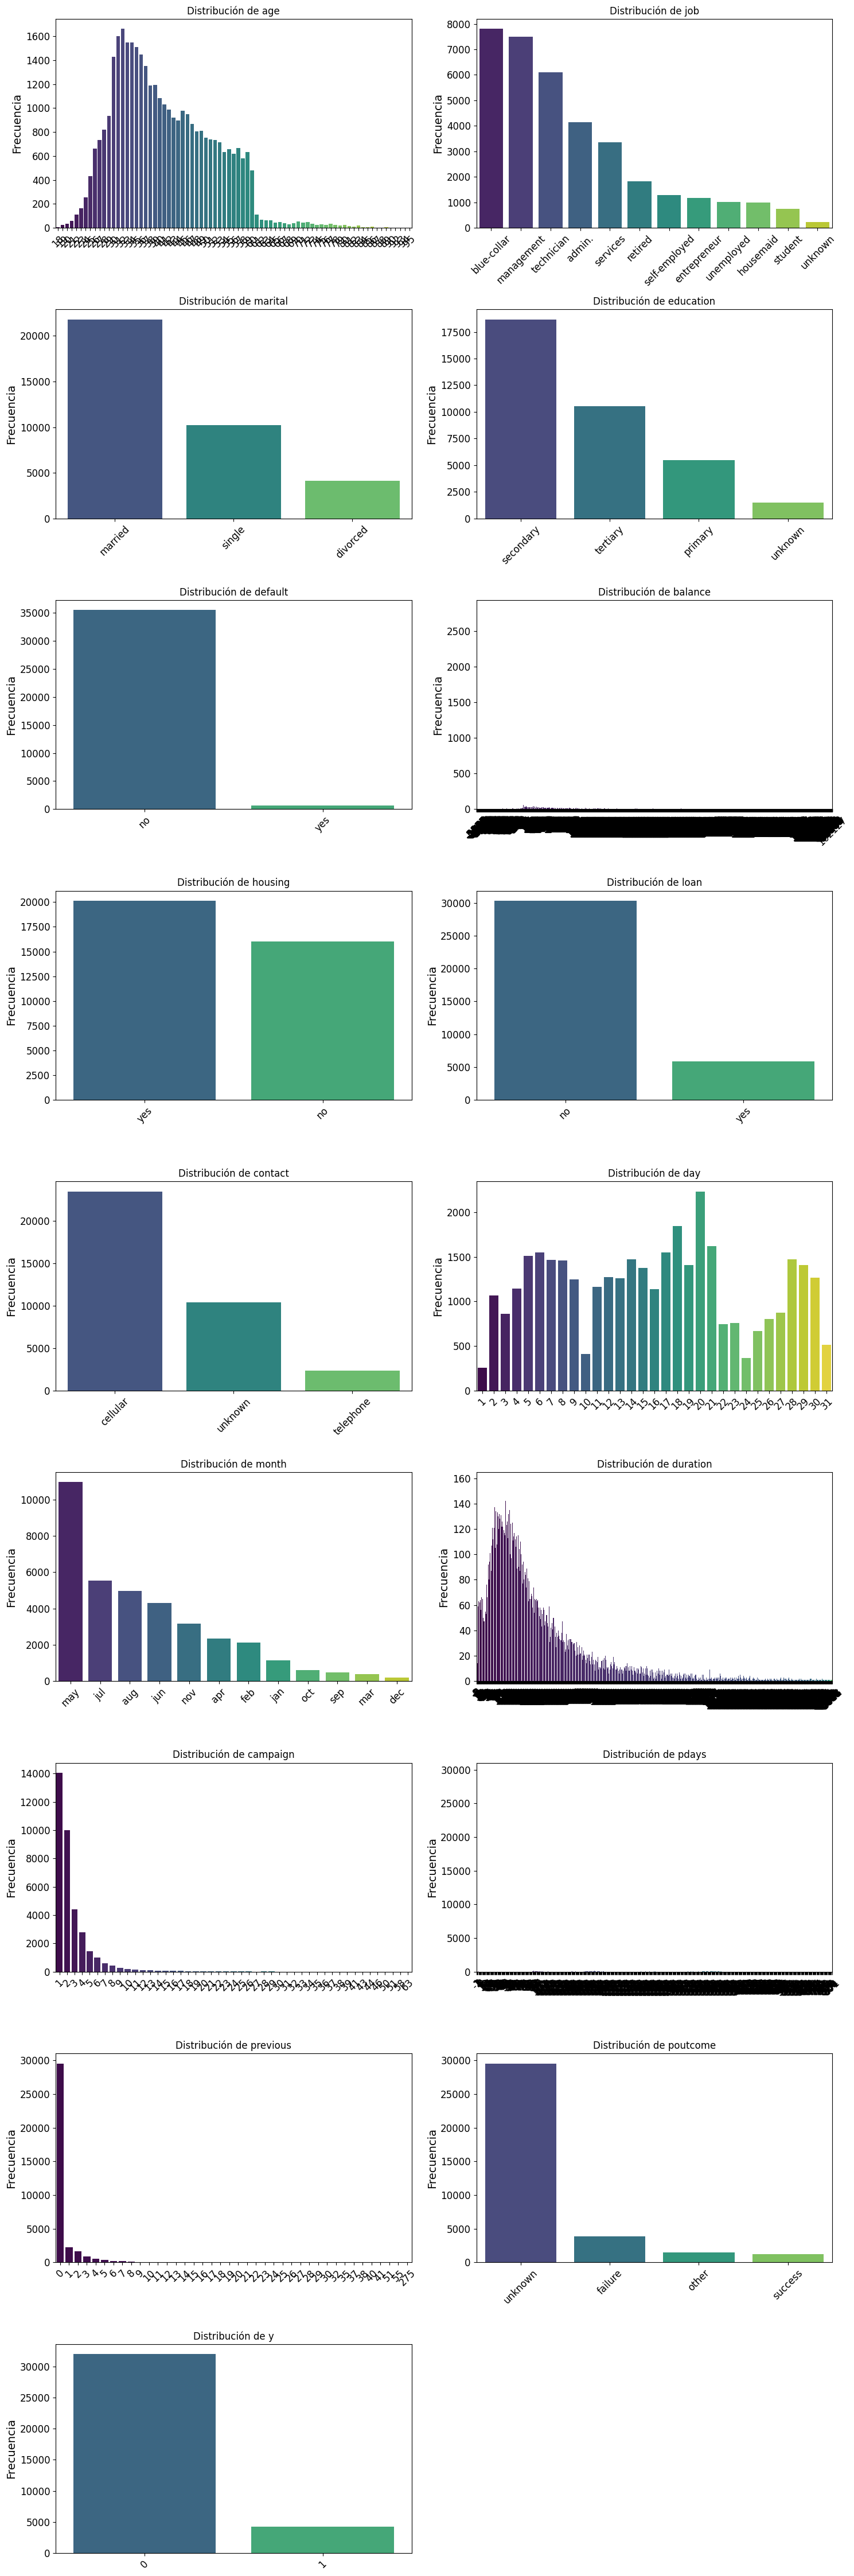

In [12]:
from bootcampviztools import pinta_distribucion_categoricas

pinta_distribucion_categoricas(df_eda, columnas_categoricas= df_eda.columns)

In [13]:
feat_num = ["age", "balance", "day", "duration", "campaing", "pdays"]
feat_cat = ["job", "marital", "education", "default","housing","loan","contact","month", "previous","poutcome"]


In [14]:
X_train =pd.get_dummies(X_train)
X_test =pd.get_dummies(X_test)

In [15]:
X_train

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,41,849,15,72,1,-1,0,False,True,False,...,False,False,True,False,False,False,False,False,False,True
17965,49,1415,30,269,2,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
18299,42,3842,31,130,4,-1,0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
10221,37,-119,11,375,11,-1,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
32192,56,3498,15,264,2,-1,0,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,1059,18,2093,1,-1,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
44732,23,508,8,210,1,92,1,False,False,False,...,False,False,False,False,False,True,True,False,False,False
38158,34,1317,15,239,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
860,33,165,7,111,1,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [16]:
tree_ml = DecisionTreeClassifier(random_state= 42)

tree_ml.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
features = X_train.columns.to_list()

TypeError: can only concatenate str (not "numpy.int64") to str

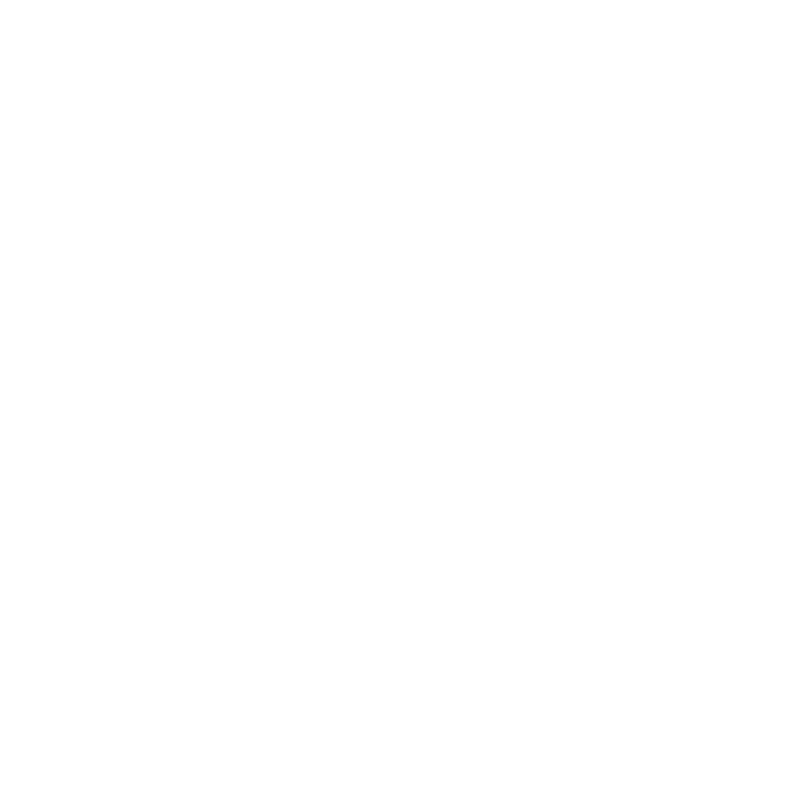

In [18]:
plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_ml,
               feature_names= features,
               class_names= y_train.unique(),
               filled = True); 

In [19]:
y_train

3344     0
17965    0
18299    0
10221    0
32192    1
        ..
11284    1
44732    0
38158    0
860      0
15795    0
Name: y, Length: 36168, dtype: int64

In [20]:
y_pred = tree_ml.predict(X_train)

In [21]:
print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

MAE: 0.0
RMSE: 0.0


In [26]:
tree_reg_bis = DecisionTreeRegressor(max_depth=8, random_state=42) # De nuevo sólo un hiperparámetro, para controlar la profundidad o número de niveles del árbol
tree_reg_bis.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

In [27]:
y_pred = tree_reg_bis.predict(X_train)

print("MAE:", mean_absolute_error(y_train, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

MAE: 0.1262251823085903
RMSE: 0.2512221947883888


In [29]:
level_2 = np.sqrt(-cross_val_score(tree_ml, X, y, cv = 5, scoring= "neg_mean_squared_error"))
level_3 = np.sqrt(-cross_val_score(tree_reg_bis, X, y, cv = 5, scoring = "neg_mean_squared_error"))

print("Arbol 2 niveles:", level_2.mean())
print("Arbol 3 niveles:", level_3.mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 959, in fit
    super()._fit(
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 242, in _fit
    X, y = self._validate_data(
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 617, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'retired'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 959, in fit
    super()._fit(
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 242, in _fit
    X, y = self._validate_data(
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 617, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'management'


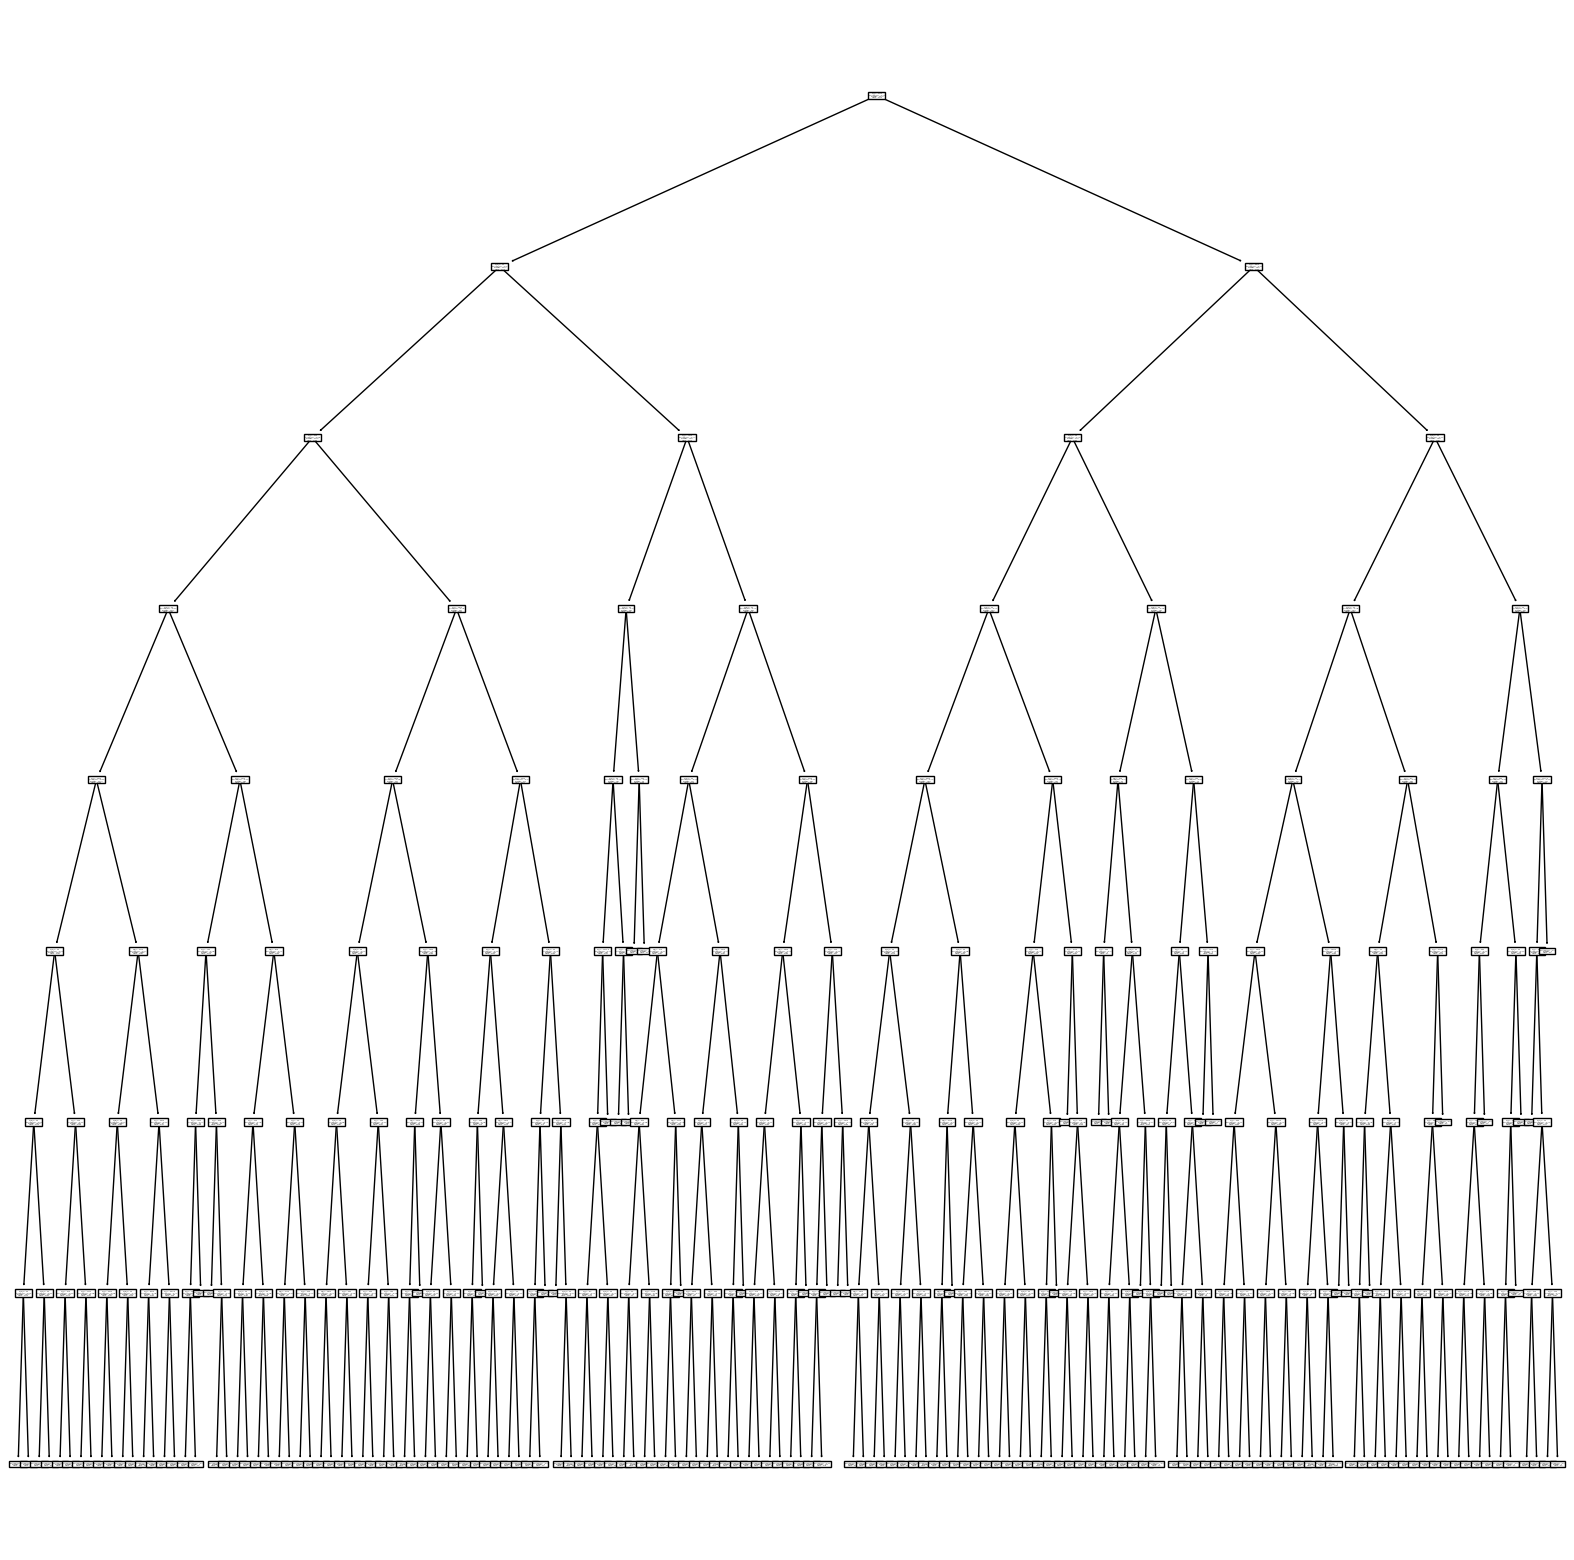

In [30]:
plt.figure(figsize=(20,20))
plot_tree(tree_reg_bis);

In [42]:
def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, X_train, y_train, 
                           cv=5, scoring= scoring).mean() 


space = {
    'alpha': hp.uniform('alpha', 0.0001, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [01:48<00:00,  1.08s/trial, best loss: -0.29652519190880045]


In [43]:
best


{'alpha': 0.001334455388961565, 'l1_ratio': 0.1544473209706126}

In [44]:
model_bayes = ElasticNet(alpha=best['alpha'], l1_ratio=best['l1_ratio'])
model_bayes.fit(X_train, y_train)
model_bayes.score(X_test, y_test)

0.30806052605567014

In [45]:
# Sigo bastante liado con esto pero por lo menos he conseguido llegar al final mas o menos